<a href="https://colab.research.google.com/github/smartgrids-aau/GreenCodesPython/blob/main/Exemple_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Choose the network type:
1. FFANN
2. GRNN Simulation
Enter your choice (1 or 2): 2


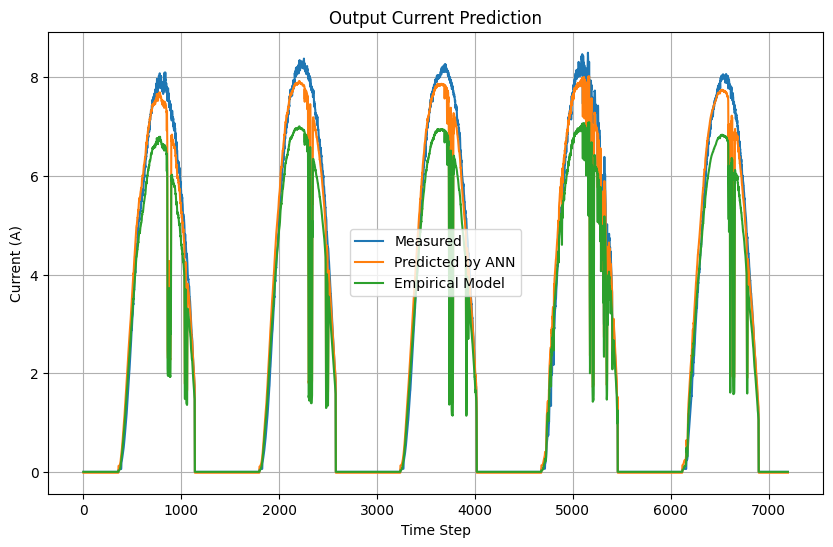

In [10]:
# Example 2.3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load Excel data
file_path = '/content/PV Modeling Book Data Source.xls'
sheet_name = 'Source 2'

# Read training data
df = pd.read_excel(file_path, sheet_name='Source 2', usecols="A:C", skiprows=1)

# Remove any rows with NaN values
df.dropna(inplace=True)

G = df.iloc[:, 0].values  # Global solar radiation
Temp = df.iloc[:, 1].values  # Ambient temperature
I_PV = df.iloc[:, 2].values  # PV actual current


# Read test data
df_test = pd.read_excel(file_path, sheet_name=sheet_name, usecols="A:C", skiprows=36002)
G_Test = df_test.iloc[:, 0].values
Temp_Test = df_test.iloc[:, 1].values
I_PV_Test = df_test.iloc[:, 2].values

# Prepare inputs
inputs = np.column_stack((G, Temp))
test_inputs = np.column_stack((G_Test, Temp_Test))

# Ask user for network type
print("Choose the network type:\n1. FFANN\n2. GRNN Simulation")
k = input("Enter your choice (1 or 2): ")

# Scale inputs
scaler = StandardScaler()
inputs_scaled = scaler.fit_transform(inputs)
test_scaled = scaler.transform(test_inputs)

# Select and train network
if k == "1":
    net = MLPRegressor(hidden_layer_sizes=(5,), solver='lbfgs', max_iter=1000, random_state=1)
elif k == "2":
    net = Ridge(alpha=1.0)  # Simulated GRNN
else:
    raise ValueError("Invalid choice")

net.fit(inputs_scaled, I_PV)
C_ANN = net.predict(test_scaled)

# Theoretical current
C_th = (G_Test / 1000) * 7.91

# Regression model (empirical)
C_Reg = -1.17112 + 0.009 * G + 0.055 * Temp

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(I_PV_Test, label='Measured')
plt.plot(C_ANN, label='Predicted by ANN')
plt.plot(C_th, label='Empirical Model')
plt.legend()
plt.title("Output Current Prediction")
plt.xlabel("Time Step")
plt.ylabel("Current (A)")
plt.grid(True)
plt.show()

# Compute evaluation metrics over averaged steps (each hour = 360 samples at 10s steps)
steps = 5760
def averaged(arr, step):
    return np.array([np.mean(arr[i:i+step]) for i in range(0, len(arr) - step + 1, step)])

AV_C_Test = averaged(I_PV_Test, steps)
AV_C_ANN = averaged(C_ANN, steps)

E3_Hour = AV_C_Test - AV_C_ANN
ANN_MAPE = np.abs(E3_Hour / AV_C_Test)
ANN_meanMAPE = np.mean(ANN_MAPE) * 100
ANN_RMSE = np.sqrt(np.mean((AV_C_ANN - AV_C_Test)**2))
ANN_MBE = np.mean(AV_C_ANN - AV_C_Test)
SUM = np.mean(AV_C_ANN)
ANN_RMSE_Percentage = (ANN_RMSE / SUM) * 100
ANN_MBE_Percentage = (ANN_MBE / SUM) * 100

import pandas as pd


metrics = pd.DataFrame({
    'ANN_meanMAPE(%)': [ANN_meanMAPE],
    'ANN_RMSE': [ANN_RMSE],
    'ANN_MBE': [ANN_MBE],
    'ANN_RMSE_Percentage(%)': [ANN_RMSE_Percentage],
    'ANN_MBE_Percentage(%)': [ANN_MBE_Percentage]
})


